In [1]:
from typing import Tuple
import numpy as np
import jax.numpy as jnp
from jax import value_and_grad
import matplotlib.pyplot as plt

import mesher
from material import StructuralMaterial
import FE_routines as fe
import mma
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [2]:
bounding_box = mesher.BoundingBox(x_min=0., x_max=60.000,
                                  y_min=0., y_max = 30.0000)
nelx, nely = 60, 30 # number of elems along X and Y axis
mesh = mesher.Mesher(nelx = nelx, nely = nely, bounding_box=bounding_box)

In [3]:
init_design = np.random.uniform(low=0., high=1., size = (mesh.num_elems, 1))

In [4]:
material = StructuralMaterial(youngs_modulus=1., poisson_ratio=0.3, mass_density=1.)

In [5]:
# Mid cant beam

force = np.zeros((2*mesh.num_nodes,1))
dofs=np.arange(2*mesh.num_nodes)
fixed = dofs[0:2*(mesh.nely+1):1]
free = jnp.setdiff1d(dofs, fixed)
force[2*(mesh.nelx+1)*(mesh.nely+1)- 1*(mesh.nely+1), 0 ] = -1.

bc = fe.BC(force = force, fixed_dofs = fixed)

In [6]:
fe_solver = fe.FEA(mesh, material, bc)
lossfn = fe_solver.loss_function  # takes in density of shape (num_elems,)

In [7]:
class Optimizer:
  def __init__(self, lossfn, mesh):
    self.lossfn, self.mesh = lossfn, mesh
  #-----------------------#
  def constraint_fn(self, density: jnp.ndarray,
                        max_vol_frac: float) -> Tuple[jnp.ndarray, jnp.ndarray]:

    def volume_constraint(density:jnp.ndarray)-> float:
      occupied_volume = jnp.einsum('i,i->i',self.mesh.elem_area, density).sum()
      volcons =  occupied_volume/(max_vol_frac*self.mesh.domain_volume) - 1.
      return volcons
    vc, dvc = value_and_grad(volume_constraint)(density.reshape((-1)))

    return jnp.array([vc]).reshape((-1,1)), dvc.reshape((1,-1))
  #-----------------------#
  def objective_fn(self, density: jnp.ndarray)-> Tuple[jnp.ndarray, jnp.ndarray]:
    obj, grad_obj = value_and_grad(self.lossfn)(density.reshape((-1)))
    return jnp.array([obj]), grad_obj.reshape((-1, 1))
  #-----------------------#
  def optimize(self, init_geom, max_vol_frac: float,
     max_iter: int, kkt_tol: float=1e-6, step_tol: float=1e-6,
      move_limit: float=5e-2, plot_interval: int=5):

    self.num_design_var = init_geom.shape[0]
    self.design_var = init_geom
    lower_bound = np.zeros((self.num_design_var, 1))
    upper_bound = np.ones((self.num_design_var, 1))
    mma_params = mma.MMAParams(
        max_iter=max_iter,
        kkt_tol=kkt_tol,
        step_tol=step_tol,
        move_limit=move_limit,
        num_design_var=self.num_design_var,
        num_cons=1,
        lower_bound=lower_bound,
        upper_bound=upper_bound,
    )
    mma_state = mma.init_mma(self.design_var, mma_params)

    def plotfun(x, status = ''):
      plt.figure()
      plt.imshow(x.reshape((self.mesh.nelx, self.mesh.nely)).T, cmap='rainbow')
      plt.title(status)
      plt.show()
    history = {'obj':[], 'vol_cons':[]}
    # MMA Loop

    while not mma_state.is_converged:
      objective, grad_obj = self.objective_fn(mma_state.x)
      constr, grad_cons = self.constraint_fn(mma_state.x, max_vol_frac)
      mma_state = mma.update_mma(
        mma_state, mma_params, objective, grad_obj, constr, grad_cons
      )
      status = (f'epoch {mma_state.epoch:d} obj {objective[0]:.2E} '
                f'vol cons {constr[0,0]:.2E} ')
      history['obj'].append(objective)
      history['vol_cons'].append(constr[0,0])

      
      print(status)
      if mma_state.epoch%plot_interval == 0 or mma_state.epoch==1:
        plotfun(mma_state.x, status)

    return mma_state, history

epoch 1 obj 5.17E+02 vol cons 1.84E-04 


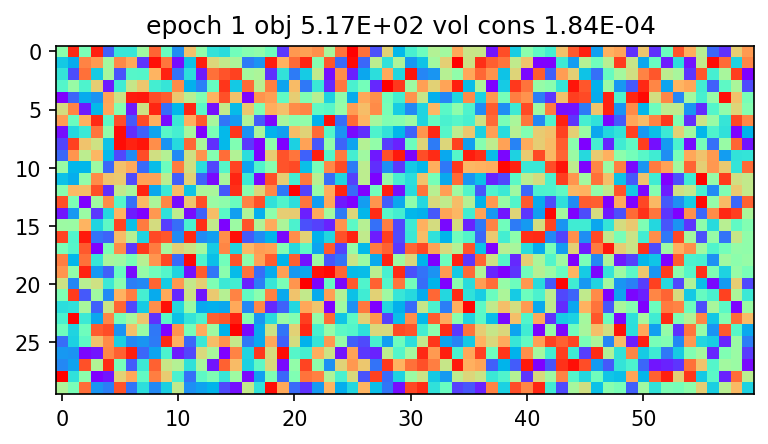

epoch 2 obj 4.49E+02 vol cons -1.23E-02 
epoch 3 obj 3.88E+02 vol cons -1.57E-02 
epoch 4 obj 3.31E+02 vol cons -1.76E-02 
epoch 5 obj 2.83E+02 vol cons -1.81E-02 
epoch 6 obj 2.43E+02 vol cons -1.77E-02 
epoch 7 obj 2.11E+02 vol cons -1.66E-02 
epoch 8 obj 1.85E+02 vol cons -1.51E-02 
epoch 9 obj 1.64E+02 vol cons -1.30E-02 
epoch 10 obj 1.48E+02 vol cons -1.12E-02 


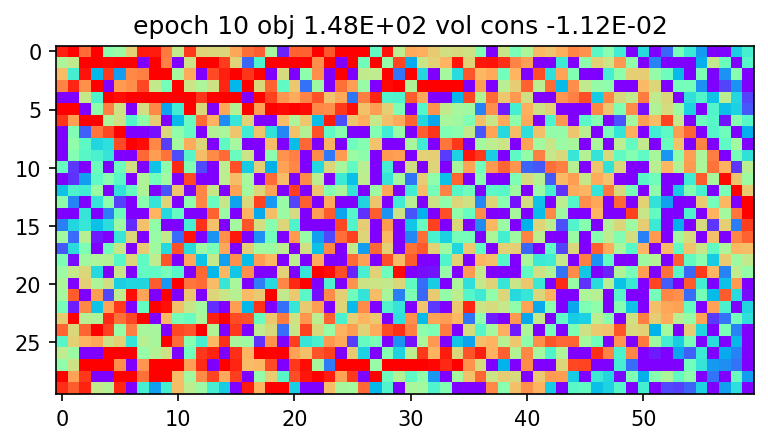

epoch 11 obj 1.34E+02 vol cons -9.57E-03 
epoch 12 obj 1.23E+02 vol cons -8.22E-03 
epoch 13 obj 1.15E+02 vol cons -7.13E-03 
epoch 14 obj 1.07E+02 vol cons -6.23E-03 
epoch 15 obj 1.01E+02 vol cons -5.39E-03 
epoch 16 obj 9.61E+01 vol cons -4.64E-03 
epoch 17 obj 9.16E+01 vol cons -4.06E-03 
epoch 18 obj 8.77E+01 vol cons -3.42E-03 
epoch 19 obj 8.46E+01 vol cons -2.78E-03 
epoch 20 obj 8.22E+01 vol cons -2.34E-03 


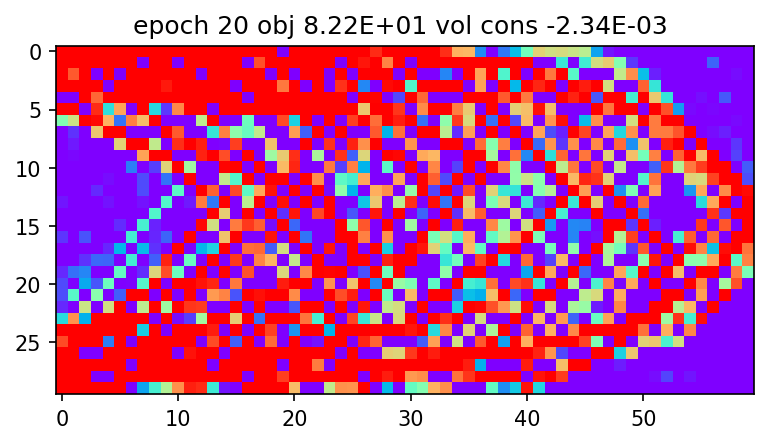

epoch 21 obj 8.03E+01 vol cons -1.91E-03 
epoch 22 obj 7.88E+01 vol cons -1.52E-03 
epoch 23 obj 7.76E+01 vol cons -1.27E-03 
epoch 24 obj 7.67E+01 vol cons -1.06E-03 
epoch 25 obj 7.59E+01 vol cons -8.66E-04 
epoch 26 obj 7.53E+01 vol cons -7.46E-04 
epoch 27 obj 7.48E+01 vol cons -6.43E-04 
epoch 28 obj 7.44E+01 vol cons -5.52E-04 
epoch 29 obj 7.40E+01 vol cons -4.64E-04 
epoch 30 obj 7.38E+01 vol cons -3.77E-04 


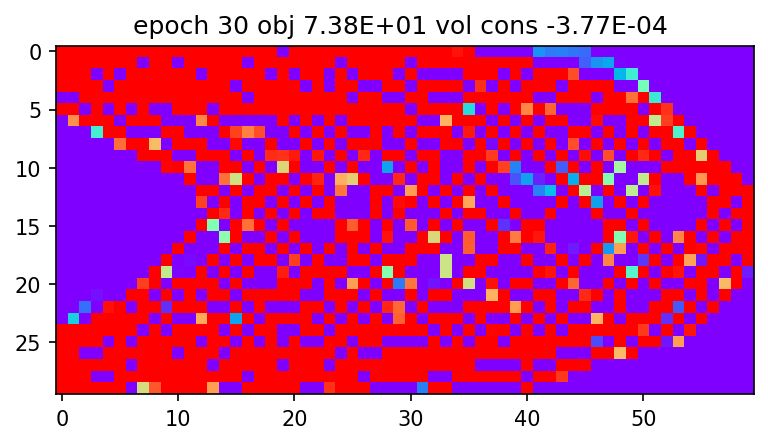

epoch 31 obj 7.35E+01 vol cons -3.04E-04 
epoch 32 obj 7.33E+01 vol cons -2.35E-04 
epoch 33 obj 7.32E+01 vol cons -1.84E-04 
epoch 34 obj 7.31E+01 vol cons -1.48E-04 
epoch 35 obj 7.30E+01 vol cons -1.06E-04 
epoch 36 obj 7.29E+01 vol cons -6.16E-05 
epoch 37 obj 7.29E+01 vol cons -3.84E-05 
epoch 38 obj 7.29E+01 vol cons -2.82E-05 
epoch 39 obj 7.28E+01 vol cons -1.85E-05 
epoch 40 obj 7.28E+01 vol cons -1.25E-05 


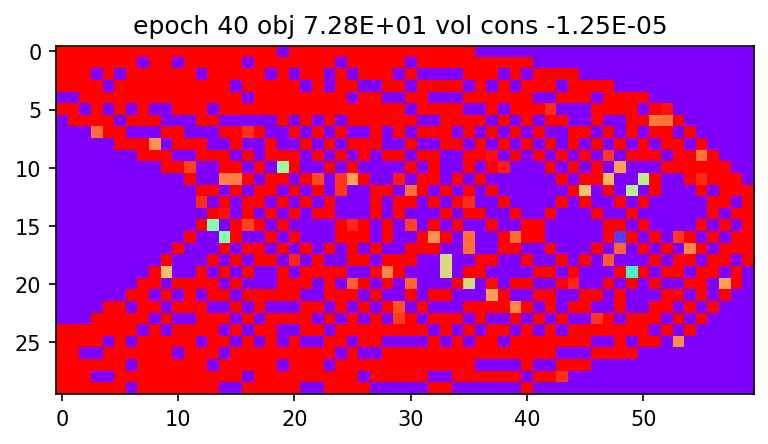

epoch 41 obj 7.28E+01 vol cons -9.89E-06 
epoch 42 obj 7.28E+01 vol cons -6.91E-06 
epoch 43 obj 7.28E+01 vol cons -3.81E-06 
epoch 44 obj 7.28E+01 vol cons -1.37E-06 
epoch 45 obj 7.28E+01 vol cons -1.19E-06 
epoch 46 obj 7.28E+01 vol cons -1.07E-06 
epoch 47 obj 7.28E+01 vol cons -7.75E-07 
epoch 48 obj 7.28E+01 vol cons -8.34E-07 
epoch 49 obj 7.28E+01 vol cons -8.94E-07 
epoch 50 obj 7.28E+01 vol cons -1.07E-06 


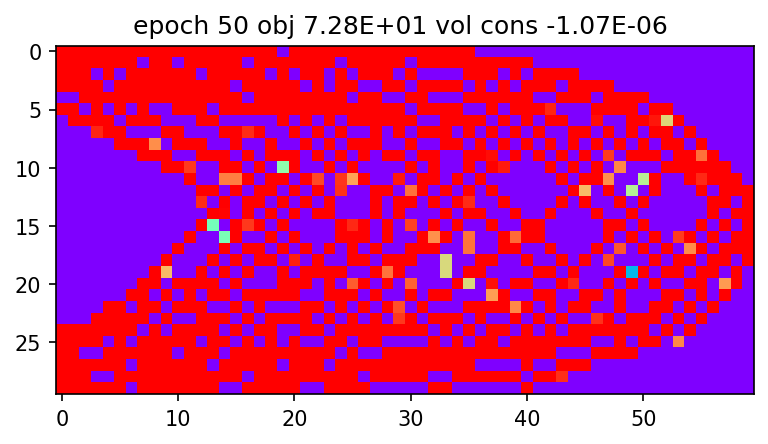

epoch 51 obj 7.28E+01 vol cons -1.67E-06 
epoch 52 obj 7.28E+01 vol cons -3.46E-06 
epoch 53 obj 7.28E+01 vol cons -3.81E-06 
epoch 54 obj 7.28E+01 vol cons -3.64E-06 
epoch 55 obj 7.28E+01 vol cons -3.76E-06 
epoch 56 obj 7.28E+01 vol cons -3.64E-06 
epoch 57 obj 7.28E+01 vol cons -6.56E-07 
epoch 58 obj 7.28E+01 vol cons -2.98E-07 
epoch 59 obj 7.28E+01 vol cons -5.36E-07 
epoch 60 obj 7.28E+01 vol cons -2.98E-07 


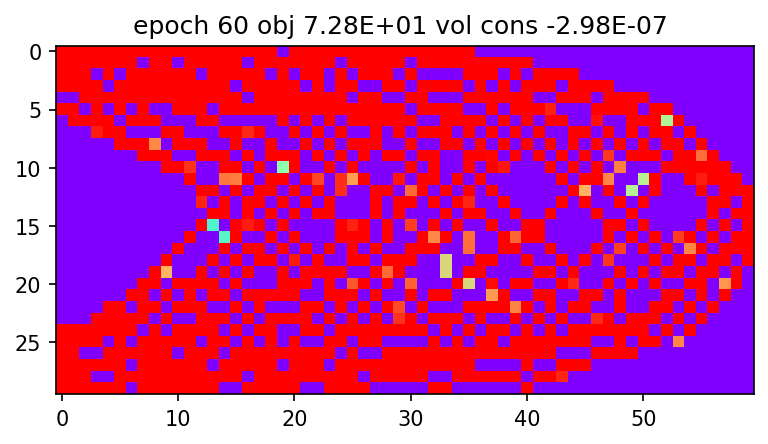

epoch 61 obj 7.28E+01 vol cons -6.56E-07 
epoch 62 obj 7.28E+01 vol cons -9.54E-07 
epoch 63 obj 7.28E+01 vol cons -1.37E-06 
epoch 64 obj 7.28E+01 vol cons -2.32E-06 
epoch 65 obj 7.28E+01 vol cons -5.01E-06 
epoch 66 obj 7.28E+01 vol cons -6.91E-06 
epoch 67 obj 7.28E+01 vol cons -6.79E-06 
epoch 68 obj 7.28E+01 vol cons -6.79E-06 
epoch 69 obj 7.28E+01 vol cons -6.68E-06 
epoch 70 obj 7.28E+01 vol cons -6.79E-06 


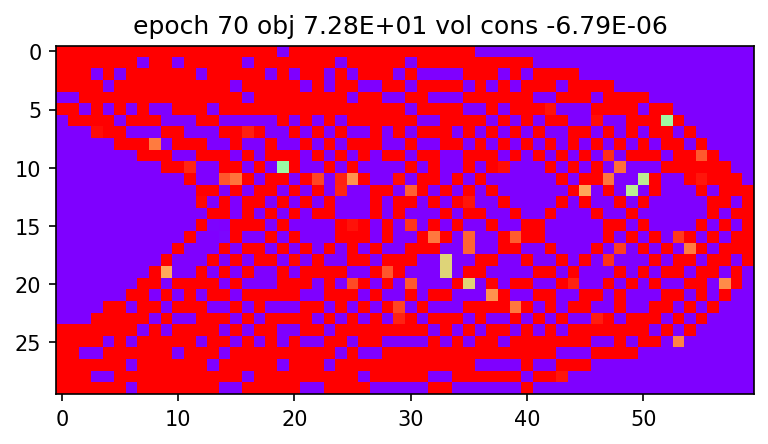

epoch 71 obj 7.28E+01 vol cons -6.79E-06 
epoch 72 obj 7.28E+01 vol cons -6.56E-07 


In [8]:
optim = Optimizer(lossfn, mesh)

mma_state, history = optim.optimize(init_design, max_vol_frac=0.5,
                                    max_iter=201,
                                    plot_interval=10)

plt.show(block=True)

In [ ]:
for k in history:
  plt.figure()
  plt.plot(history[k])
  plt.xlabel('iter')
  plt.ylabel(f'{k}')